<a href="https://colab.research.google.com/github/ChacoGolden/DSML_EV/blob/main/graph_start_video.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

In [ ]:
car_df = pd.read_csv('https://raw.githubusercontent.com/ChacoGolden/DSML_EV/refs/heads/main/CH_vehicles_ev_percentage.csv')
pm10 = pd.read_csv('https://raw.githubusercontent.com/ChacoGolden/DSML_EV/refs/heads/main/PM10_emissions_CH.csv')
no2 = pd.read_csv('https://raw.githubusercontent.com/ChacoGolden/DSML_EV/refs/heads/main/No2_emissions_CH.csv')
co2 = pd.read_csv('https://raw.githubusercontent.com/ChacoGolden/DSML_EV/refs/heads/main/CO2_carb_comb.csv')
swiss_data = pd.read_csv('https://raw.githubusercontent.com/ChacoGolden/DSML_EV/refs/heads/main/swiss_final_dataset_1995_2023.csv')

In [ ]:
# Transpose and clean if not already done
car_df_t = car_df.T.copy()
car_df_t.columns = car_df_t.iloc[0]  # Set the fuel types as column names
car_df_t = car_df_t.drop(car_df_t.index[0])  # Remove the label row
car_df_t.index = car_df_t.index.astype(int)
car_df_t = car_df_t.astype(float)

# Extract % EV and reformat
ev_percent_df = car_df_t[['% EV vs Fossil']].reset_index()
ev_percent_df.columns = ['date', 'EV_percent']
# Merge % EV with all_data
all_data = pd.merge(all_data, ev_percent_df, on='date', how='left')


In [ ]:
# Rename and select relevant columns
industry_df = swiss_data[['year', 'industry_pct_gdp']].copy()
industry_df.columns = ['date', 'industry_pct']

# Filter to 2002–2024
industry_df = industry_df[(industry_df['date'] >= 2002) & (industry_df['date'] <= 2024)]


In [ ]:
# Merge with all_data
all_data_industry = pd.merge(all_data, industry_df, on='date', how='left')

In [ ]:
# Get values for 2009 and 2012
val_2009 = all_data_industry.loc[all_data_industry['date'] == 2009, 'industry_pct'].values[0]
val_2012 = all_data_industry.loc[all_data_industry['date'] == 2012, 'industry_pct'].values[0]

# Compute linear interpolation for 2010
interp_2010 = (val_2009 + val_2012) / 2

# Assign to 2010
all_data_industry.loc[all_data_industry['date'] == 2010, 'industry_pct'] = interp_2010

print(f"Filled 2010 with interpolated value: {interp_2010:.4f}")


Filled 2010 with interpolated value: 24.6733


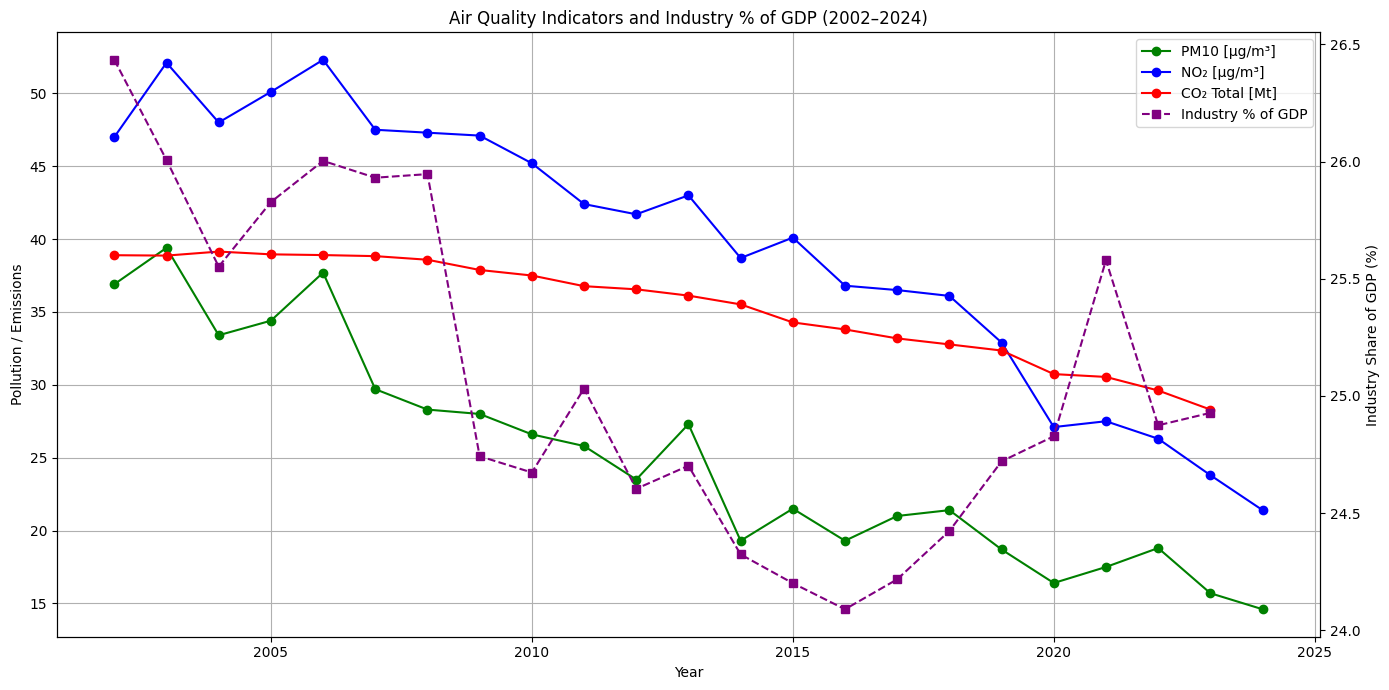

In [ ]:
# Create the plot
fig, ax1 = plt.subplots(figsize=(14, 7))

# Left Y-axis: air quality and CO2
ax1.plot(all_data_industry['date'], all_data_industry['PM10 [ug/m3]'], label='PM10 [µg/m³]', marker='o', color='green')
ax1.plot(all_data_industry['date'], all_data_industry['NO2 [ug/m3]'], label='NO₂ [µg/m³]', marker='o', color='blue')
ax1.plot(all_data_industry['date'], all_data_industry['CO2_total'], label='CO₂ Total [Mt]', marker='o', color='red')
ax1.set_xlabel('Year')
ax1.set_ylabel('Pollution / Emissions')
ax1.grid(True)

# Right Y-axis: industry % of GDP
ax2 = ax1.twinx()
ax2.plot(all_data_industry['date'], all_data_industry['industry_pct'], label='Industry % of GDP', marker='s', color='purple', linestyle='--')
ax2.set_ylabel('Industry Share of GDP (%)')

# Combine legends
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right')

plt.title('Air Quality Indicators and Industry % of GDP (2002–2024)')
plt.tight_layout()
plt.show()


In [ ]:
print("Correlation PM10 vs Industry GDP %:", all_data_industry[['PM10 [ug/m3]', 'industry_pct']].corr().iloc[0, 1])
print("Correlation PM10 vs % EV:", all_data_industry[['PM10 [ug/m3]', 'EV_percent']].corr().iloc[0, 1])  # if EV included


Correlation PM10 vs Industry GDP %: 0.7348378907874585
Correlation PM10 vs % EV: -0.6552001740626102


In [ ]:
# Reuse car_df_t if already transposed
ev_df = car_df_t[['% EV vs Fossil']].reset_index()
ev_df.columns = ['date', 'EV_percent']
ev_df['EV_percent'] = ev_df['EV_percent'].astype(float)

# Filter years and fill missing if needed
ev_df = ev_df[(ev_df['date'] >= 2002) & (ev_df['date'] <= 2024)]
ev_df['EV_percent'] = ev_df['EV_percent'].interpolate(method='linear')

# Merge into main dataframe
all_data_ev = pd.merge(all_data, ev_df, on='date', how='left')

# Smooth EV %
all_data_ev['EV_percent_smooth'] = all_data_ev['EV_percent'].rolling(window=3, center=True).mean()


MergeError: Passing 'suffixes' which cause duplicate columns {'EV_percent_x'} is not allowed.

In [ ]:
# Convert year to integer
co2['Année'] = co2['Année'].astype(int)

# Keep only 'Année' and 'Emissions totale', rename columns for consistency
co2_clean = co2[['Année', 'Emissions totale']].copy()
co2_clean.columns = ['date', 'CO2_total']

# Filter to match the NO2/PM10 date range
co2_filtered = co2_clean[(co2_clean['date'] >= 2002) & (co2_clean['date'] <= 2024)]


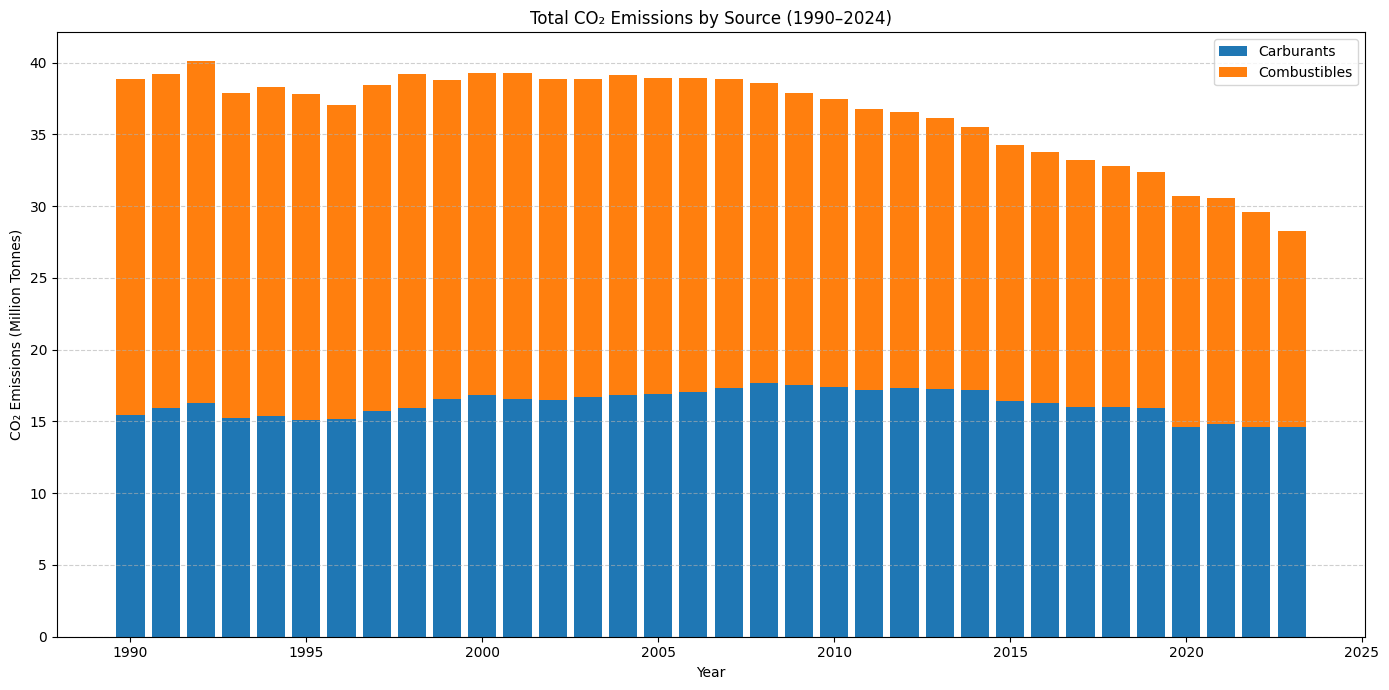

In [ ]:
import matplotlib.pyplot as plt

# Step 1: Clean and convert relevant columns
co2['Année'] = co2['Année'].astype(int)
co2['carburant'] = co2["Emissions liées aux carburants, en millions de tonnes de CO2"].astype(float)
co2['combustible'] = co2["Emissions liées aux combustibles, en millions de tonnes de CO2"].astype(float)

# Step 2: Filter years if needed (e.g., from 1990 to 2024)
co2_filtered = co2[(co2['Année'] >= 1990) & (co2['Année'] <= 2024)]

# Step 3: Plot stacked bar chart
plt.figure(figsize=(14, 7))
plt.bar(co2_filtered['Année'], co2_filtered['carburant'], label='Carburants')
plt.bar(co2_filtered['Année'], co2_filtered['combustible'],
        bottom=co2_filtered['carburant'], label='Combustibles')

# Styling
plt.title('Total CO₂ Emissions by Source (1990–2024)')
plt.xlabel('Year')
plt.ylabel('CO₂ Emissions (Million Tonnes)')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


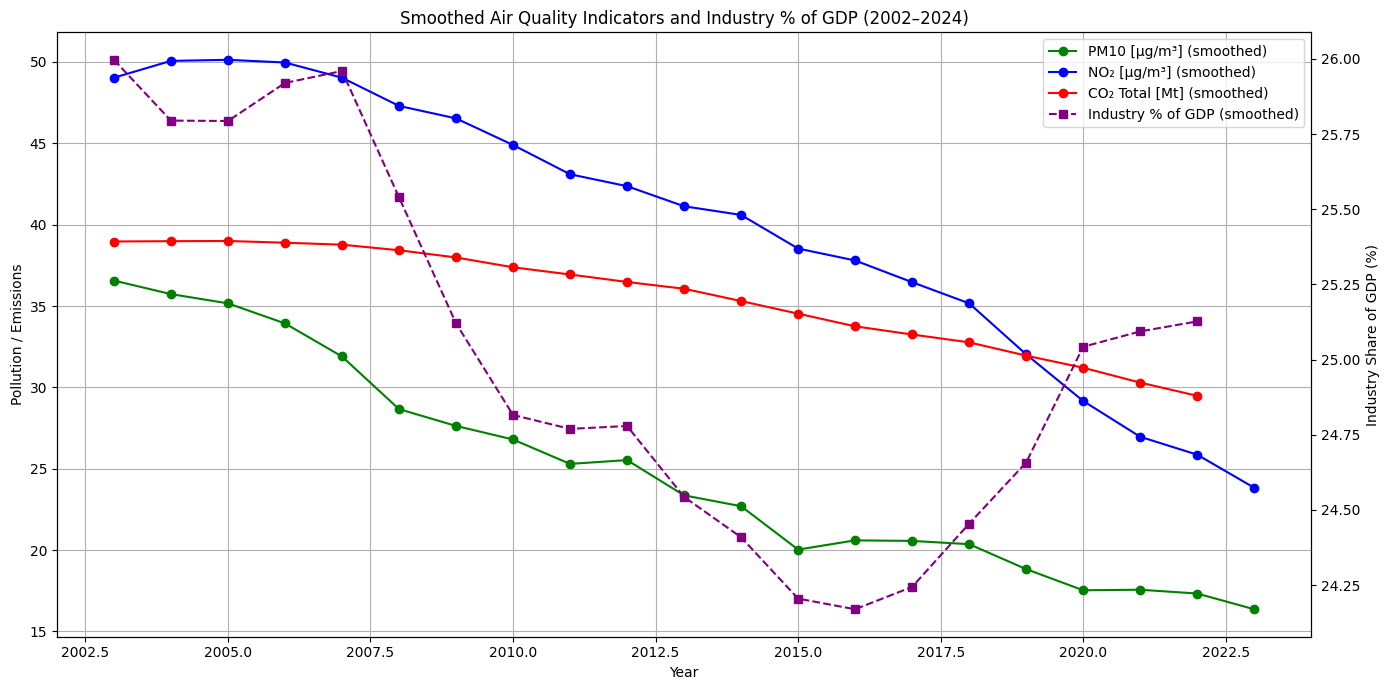

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Create smoothed columns using a centered 3-year rolling average
all_data_industry['PM10_smooth'] = all_data_industry['PM10 [ug/m3]'].rolling(window=3, center=True).mean()
all_data_industry['NO2_smooth'] = all_data_industry['NO2 [ug/m3]'].rolling(window=3, center=True).mean()
all_data_industry['CO2_smooth'] = all_data_industry['CO2_total'].rolling(window=3, center=True).mean()
all_data_industry['industry_pct_smooth'] = all_data_industry['industry_pct'].rolling(window=3, center=True).mean()

# Create the plot
fig, ax1 = plt.subplots(figsize=(14, 7))

# Left Y-axis: smoothed air quality indicators
ax1.plot(all_data_industry['date'], all_data_industry['PM10_smooth'], label='PM10 [µg/m³] (smoothed)', marker='o', color='green')
ax1.plot(all_data_industry['date'], all_data_industry['NO2_smooth'], label='NO₂ [µg/m³] (smoothed)', marker='o', color='blue')
ax1.plot(all_data_industry['date'], all_data_industry['CO2_smooth'], label='CO₂ Total [Mt] (smoothed)', marker='o', color='red')
ax1.set_xlabel('Year')
ax1.set_ylabel('Pollution / Emissions')
ax1.grid(True)

# Right Y-axis: smoothed industry share
ax2 = ax1.twinx()
ax2.plot(all_data_industry['date'], all_data_industry['industry_pct_smooth'],
         label='Industry % of GDP (smoothed)', marker='s', color='purple', linestyle='--')
ax2.set_ylabel('Industry Share of GDP (%)')

# Legends
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right')

# Title
plt.title('Smoothed Air Quality Indicators and Industry % of GDP (2002–2024)')
plt.tight_layout()
plt.show()
